# Hypothesis 3: As children gain experience with the task, they may become more efficient in their information-seeking strategies, which may lead to fewer mistakes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, kruskal, sem, f_oneway
from sklearn.utils import resample
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gamma
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Dataset

In [2]:
dataset = 'data_thesis.csv'
data = pd.read_csv(dataset)
data.drop(data[data['period_in_trial'] == 'feedback'].index, inplace=True)
data.drop(data[data['sideMatch'] == 'timedout'].index, inplace=True)
data.drop(data[data['accuracy'] == 0.5].index, inplace=True)

# Filter out participants that completed 10 or less trials

trial_counts_per_session = data.groupby('session')['trialno'].nunique()
trial_counts_df = trial_counts_per_session.reset_index(name='unique_trial_count')
data_original = data[data['session'].isin(trial_counts_df[trial_counts_df['unique_trial_count'] > 10]['session'])]

data_original['durLookBottom'] = data_original['LookTotDurInL'] + data_original['LookTotDurInR'] #New variable: durLookBottom
data_original['FixNbInBottom'] = data_original['FixNbInL'] + data_original['FixNbInR'] #New variable: FixNbInBottom
data_original['durfixBottom'] = data_original['FixTotDurInL'] + data_original['FixTotDurInR'] #New variable: durFixBottom


data_original

C:\Users\I587504\AppData\Local\Temp\ipykernel_72560\1923591256.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original['durLookBottom'] = data_original['LookTotDurInL'] + data_original['LookTotDurInR'] #New variable: durLookBottom
C:\Users\I587504\AppData\Local\Temp\ipykernel_72560\1923591256.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original['FixNbInBottom'] = data_original['FixNbInL'] + data_original['FixNbInR'] #New variable: FixNbInBottom
C:\Users\I587504\AppData\Local\Temp\ip

,session,trialno,difficulty,accuracy,period_in_trial,step_reached,durPeriodTotal,FixNb,FixNbInL,FixNbInR,...,objL,objR,objT,sideChosen,sideMatch,timePeriodStarts,timePeriodEnds,durLookBottom,FixNbInBottom,durfixBottom
0,curE002a,8,Easy,0.0,exploration,3,11270,20,13,5,...,V-1-G-1.png,F-4-E-1.png,F-4-E-1.png,left,right,1962.0,13230.0,5480,18,4952
1,curE002a,8,Easy,0.0,decision,3,924,2,1,0,...,V-1-G-1.png,F-4-E-1.png,F-4-E-1.png,left,right,13232.0,14154.0,536,1,536
3,curE002a,9,Easy,1.0,exploration,3,2498,6,3,2,...,F-1-A-3.png,V-2-H-2.png,F-1-A-3.png,left,left,2024.0,4520.0,1670,5,1468
4,curE002a,9,Easy,1.0,decision,3,2182,4,1,0,...,F-1-A-3.png,V-2-H-2.png,F-1-A-3.png,left,left,4522.0,6702.0,530,1,470
6,curE002a,10,Easy,1.0,exploration,3,9912,11,3,5,...,F-4-E-1.png,V-1-G-1.png,V-1-G-1.png,right,right,2046.0,11956.0,2658,8,2546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,curE122a,43,Hard,0.0,exploration,1,20008,20,20,0,...,O-2-J-1.png,O-2-G-4.png,O-2-G-4.png,left,right,4456.0,7984.0,5162,20,3806
5788,curE122a,45,Medium,1.0,exploration,3,3530,2,0,1,...,O-3-B-4.png,O-1-D-2.png,O-3-B-4.png,left,left,1650.0,3980.0,114,1,114
5790,curE122a,46,Medium,0.0,decision,3,1716,5,2,0,...,V-4-G-3.png,V-1-A-4.png,V-1-A-4.png,left,right,20952.0,23084.0,464,2,434
5791,curE122a,48,Medium,0.0,exploration,3,2332,2,1,0,...,V-2-B-3.png,V-3-H-3.png,V-3-H-3.png,left,right,1488.0,17710.0,596,1,596


In [3]:
# DF DATA PER TRIAL

# Exploration period duration
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
durExplorationTotal_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()
durExplorationTotal_df.rename(columns={'durPeriodTotal': 'durExplorationPeriod'}, inplace=True)                                              

# Decision period duration
decision_df = data_original[data_original['period_in_trial'] == 'decision']
durDecisionTotal_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['durPeriodTotal'].sum().reset_index()
durDecisionTotal_df.rename(columns={'durPeriodTotal': 'durDecisionPeriod'}, inplace=True)

# Trial duration
trialduration_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

# Accuracy
decision_df = data_original[data_original['period_in_trial'] == 'decision']
accuracy_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['accuracy'].sum().reset_index()

# Side Chosen
decision_df = data_original[data_original['period_in_trial'] == 'decision']
sideChosen_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['sideChosen'].sum().reset_index()

#Number of switches during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
SwitchesExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesExploration_df.rename(columns={'NbSwitches': 'SwitchesExplorationPeriod'}, inplace=True)   

#Number of switches during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
SwitchesDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesDecision_df.rename(columns={'NbSwitches': 'SwitchesDecisionPeriod'}, inplace=True)   

#Number of switches in total
SwitchesTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()

#Fixation number during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbExploration_df.rename(columns={'FixNb': 'FixNbExplorationPeriod'}, inplace=True)   

#Fixation number during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbDecision_df.rename(columns={'FixNb': 'FixNbDecisionPeriod'}, inplace=True)   

#Fixation number in total
FixNbTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()

#Fixation number in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbTD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTD_df.rename(columns={'FixNbInT': 'FixNbInTDecision'}, inplace=True)   

#Fixation number in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbTE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTE_df.rename(columns={'FixNbInT': 'FixNbInTExploration'}, inplace=True) 

#Fixation number in Bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbBottom_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()
FixNbBottom_df.rename(columns={'FixNbInBottom': 'FixNbInBottomExploration'}, inplace=True)

#Fixation number in Bottom during both periods
FixNbBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()

#Fixation number in Top during both periods
FixNbInTTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()

# Look total duration in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTDecision_df.rename(columns={'LookTotDurInT': 'LookDurInTDecision'}, inplace=True)   

# Look total duration in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTExploration_df.rename(columns={'LookTotDurInT': 'LookDurInTExploration'}, inplace=True)  

# Look total duration in bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
LookDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBE_df.rename(columns={'durLookBottom': 'durLookBottomExploration'}, inplace=True)

# Look total duration in bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBD_df.rename(columns={'durLookBottom': 'durLookBottomDecision'}, inplace=True)

# Look total duration in Bottom cards during both periods
LookDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()

# Look total duration in Top Card during both periods
LookDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()

# Fixation duration of top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTDecision_df.rename(columns={'FixTotDurInT': 'FixDurInTDecision'}, inplace=True)   

# Fixation duration of top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTExploration_df.rename(columns={'FixTotDurInT': 'FixDurInTExploration'}, inplace=True)  

# Fixation duration of bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBE_df.rename(columns={'durfixBottom': 'durfixBottomExploration'}, inplace=True)

# Fixation duration of bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBD_df.rename(columns={'durfixBottom': 'durfixBottomDecision'}, inplace=True)

# Fixation duration of Bottom cards during both periods
FixDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()

# Fixation duration of Top card during both periods
FixDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()

merged_filtered_data = accuracy_df.merge(sideChosen_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(trialduration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durExplorationTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durDecisionTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(SwitchesTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(FixNbExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottom_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbInTTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(LookDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')


merged_filtered_data = merged_filtered_data.merge(FixDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.dropna() 
merged_filtered_data

,session,trialno,difficulty,accuracy,sideChosen,durPeriodTotal,durExplorationPeriod,durDecisionPeriod,NbSwitches,SwitchesExplorationPeriod,...,durLookBottomExploration,durLookBottomDecision,durLookBottom,LookTotDurInT,FixDurInTDecision,FixDurInTExploration,durfixBottomExploration,durfixBottomDecision,durfixBottom,FixTotDurInT
0,curE002a,8,Easy,0.0,left,12194,11270.0,924.0,6,6.0,...,5480.0,536.0,6016,1208,298.0,298.0,4952.0,536.0,5488,1148
1,curE002a,9,Easy,1.0,left,4680,2498.0,2182.0,2,2.0,...,1670.0,530.0,2200,2176,1466.0,1466.0,1468.0,470.0,1938,1942
2,curE002a,10,Easy,1.0,right,12826,9912.0,2914.0,4,3.0,...,2658.0,106.0,2764,2020,798.0,798.0,2546.0,364.0,2910,1774
3,curE002a,11,Medium,1.0,right,3910,2328.0,1582.0,3,2.0,...,994.0,470.0,1464,1780,646.0,646.0,960.0,420.0,1380,1540
4,curE002a,12,Medium,0.0,left,15256,14272.0,984.0,6,5.0,...,7554.0,476.0,8030,1296,406.0,406.0,7048.0,476.0,7524,1210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,curE122a,27,Medium,1.0,left,14690,13092.0,1598.0,2,2.0,...,9398.0,394.0,9792,1484,876.0,876.0,8682.0,308.0,8990,1244
1289,curE122a,28,Medium,1.0,right,14362,13796.0,566.0,4,3.0,...,6946.0,474.0,7420,288,0.0,0.0,6152.0,474.0,6626,212
1290,curE122a,35,Hard,1.0,left,18326,16894.0,1432.0,5,5.0,...,11690.0,0.0,11690,118,0.0,0.0,10078.0,0.0,10078,114
1291,curE122a,38,Hard,1.0,left,2996,2414.0,582.0,3,2.0,...,1586.0,488.0,2074,502,0.0,0.0,1510.0,488.0,1998,442


## Cumulative accuracy

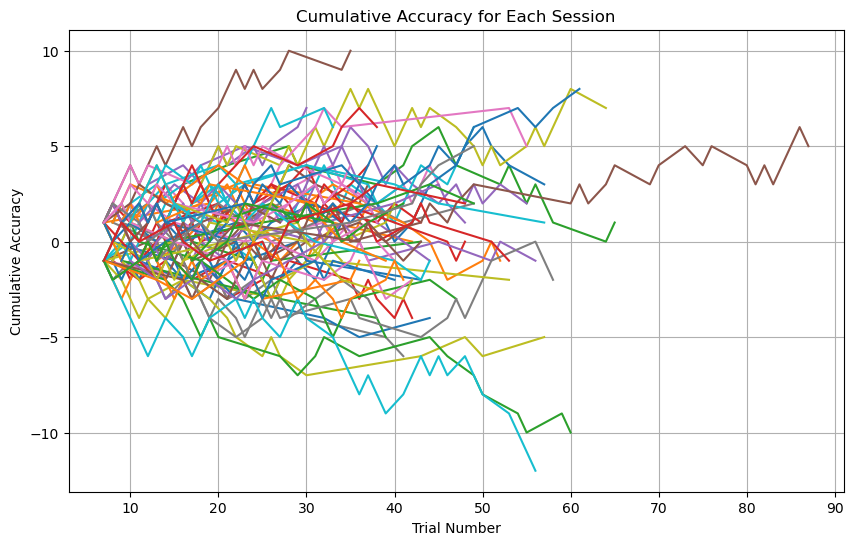

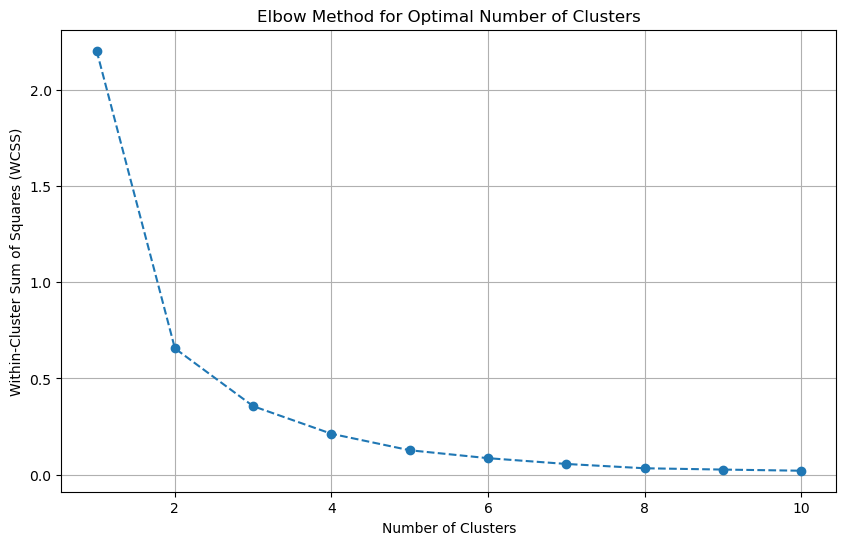

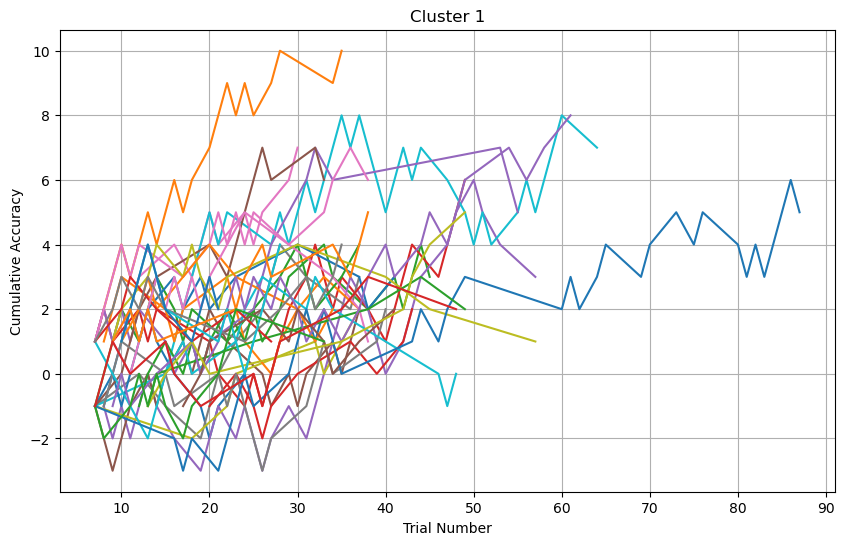

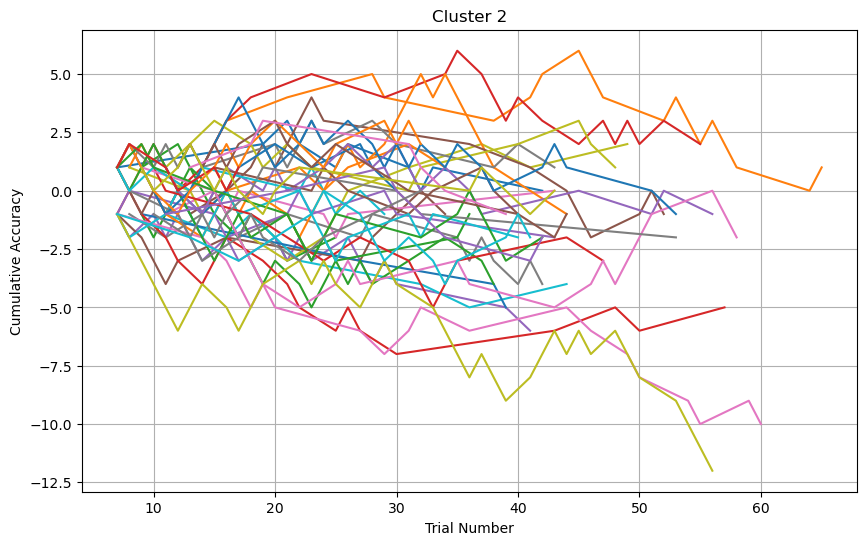

Cluster 1: curE002a, curE011a, curE012a, curE017a, curE018a, curE019a, curE027a, curE030a, curE032a, curE038a, curE039a, curE041a, curE045a, curE048a, curE049a, curE052a, curE063a, curE066a, curE067a, curE072a, curE075a, curE084a, curE086a, curE094a, curE106a, curE108a, curE109a, curE113a, curE114a, curE115a, curE118a, curE119a, curE121a, curE122a
Cluster 2: curE003a, curE004a, curE008a, curE009a, curE013a, curE014a, curE020a, curE024a, curE034a, curE040a, curE043a, curE046a, curE050a, curE051a, curE053a, curE054a, curE055a, curE056a, curE058a, curE062a, curE064a, curE069a, curE070a, curE071a, curE074a, curE076a, curE078a, curE079a, curE080a, curE082a, curE090a, curE092a, curE098a, curE099a, curE100a, curE104a, curE107a, curE111a, curE112a, curE120a


In [17]:
# Cumulative accuracy over trials for each session
# For each correct trial, it adds 1, and for each incorrect trial, it subtracts 1
#Clustering

warnings.filterwarnings("ignore")
cumulative_accuracy_data = []

for session, session_data in merged_filtered_data.groupby('session'):
    cumulative_accuracy = 0
    for index, trial in session_data.iterrows():
        if trial['accuracy'] == 1:
            cumulative_accuracy += 1
        else:
            cumulative_accuracy -= 1
        cumulative_accuracy_data.append({'session': session, 'trialno': trial['trialno'], 'cumulative_accuracy': cumulative_accuracy})

cumulative_accuracy_df = pd.DataFrame(cumulative_accuracy_data)

plt.figure(figsize=(10, 6))
for session, session_data in cumulative_accuracy_df.groupby('session'):
    plt.plot(session_data['trialno'], session_data['cumulative_accuracy'], label=f'Session {session}')

plt.xlabel('Trial Number')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy for Each Session')
#plt.legend()
plt.grid(True)
plt.show()

# Calculating slope for each session
slope_data = []

for session, session_data in cumulative_accuracy_df.groupby('session'):
    trial_numbers = session_data['trialno']
    cumulative_accuracies = session_data['cumulative_accuracy']
    slopes = np.diff(cumulative_accuracies) / np.diff(trial_numbers)
    avg_slope = np.mean(slopes)
    slope_data.append({'session': session, 'average_slope': avg_slope})

slope_df = pd.DataFrame(slope_data)

# Clustering babies according to their tendency

wcss = []
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(slope_df[['average_slope']])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

optimal_num_clusters = 2
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
clusters = kmeans.fit_predict(slope_df[['average_slope']])

for i in range(optimal_num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_sessions = slope_df[clusters == i]['session']
    for session in cluster_sessions:
        session_data = cumulative_accuracy_df[cumulative_accuracy_df['session'] == session]
        plt.plot(session_data['trialno'], session_data['cumulative_accuracy'], label=f'Session {session}')
    plt.xlabel('Trial Number')
    plt.ylabel('Cumulative Accuracy')
    plt.title(f'Cluster {i+1}')
    #plt.legend()
    plt.grid(True)
    plt.show()

for i in range(optimal_num_clusters):
    sessions_in_cluster = slope_df.loc[clusters == i, 'session']
    print(f"Cluster {i+1}: {', '.join(map(str, sessions_in_cluster))}")

In [18]:
#Creating a new column called cumulative accuracy
# For each correct trial, it adds 1, and for each incorrect trial, it subtracts 1

merged_filtered_data['cumulative_accuracy'] = 0

for session, session_data in merged_filtered_data.groupby('session'):
    cumulative_accuracy = 0
    for index, trial in session_data.iterrows():
        if index == session_data.index[0]:
            cumulative_accuracy = 0  
        if trial['accuracy'] == 1:
            cumulative_accuracy += 1
        else:
            cumulative_accuracy -= 1
        merged_filtered_data.at[index, 'cumulative_accuracy'] = cumulative_accuracy

pd.set_option('display.max_rows', None)

merged_filtered_data

,session,trialno,difficulty,accuracy,sideChosen,durPeriodTotal,durExplorationPeriod,durDecisionPeriod,NbSwitches,SwitchesExplorationPeriod,...,durLookBottomDecision,durLookBottom,LookTotDurInT,FixDurInTDecision,FixDurInTExploration,durfixBottomExploration,durfixBottomDecision,durfixBottom,FixTotDurInT,cumulative_accuracy
0,curE002a,8,Easy,0.0,left,12194,11270.0,924.0,6,6.0,...,536.0,6016,1208,298.0,298.0,4952.0,536.0,5488,1148,-1
1,curE002a,9,Easy,1.0,left,4680,2498.0,2182.0,2,2.0,...,530.0,2200,2176,1466.0,1466.0,1468.0,470.0,1938,1942,0
2,curE002a,10,Easy,1.0,right,12826,9912.0,2914.0,4,3.0,...,106.0,2764,2020,798.0,798.0,2546.0,364.0,2910,1774,1
3,curE002a,11,Medium,1.0,right,3910,2328.0,1582.0,3,2.0,...,470.0,1464,1780,646.0,646.0,960.0,420.0,1380,1540,2
4,curE002a,12,Medium,0.0,left,15256,14272.0,984.0,6,5.0,...,476.0,8030,1296,406.0,406.0,7048.0,476.0,7524,1210,1
5,curE002a,13,Medium,1.0,left,15846,13628.0,2218.0,7,6.0,...,576.0,7244,2850,1138.0,1138.0,6218.0,522.0,6740,2516,2
6,curE002a,14,Medium,0.0,left,6926,5326.0,1600.0,3,3.0,...,540.0,3704,1352,994.0,994.0,2950.0,540.0,3490,1292,1
7,curE002a,16,Medium,0.0,left,4478,2328.0,2150.0,1,1.0,...,446.0,1446,1726,648.0,648.0,946.0,342.0,1288,1598,0
8,curE002a,19,Medium,0.0,left,7128,5928.0,1200.0,2,2.0,...,534.0,1972,854,432.0,432.0,1340.0,476.0,1816,690,-1
9,curE002a,20,Medium,0.0,right,9080,3648.0,5432.0,4,3.0,...,256.0,2706,4368,3170.0,3170.0,2262.0,256.0,2518,3808,-2


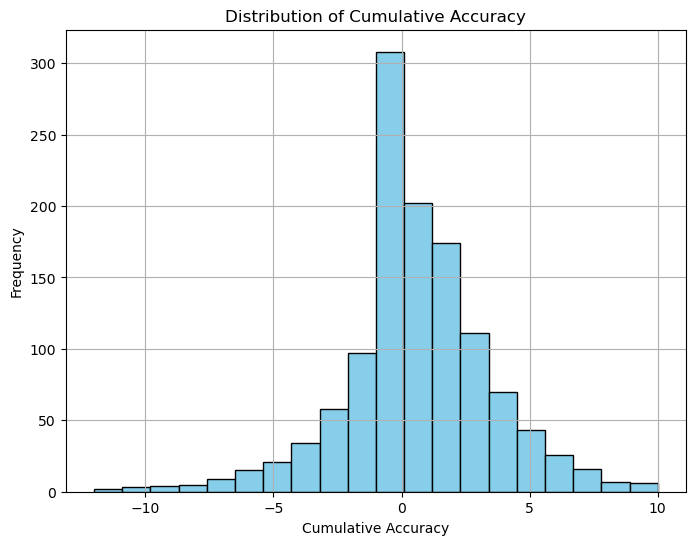

Data does not look normally distributed (reject H0)
Best fit distribution: beta


In [19]:
# Distribution of Cumulative Accuracy

cum_accuracy_data = merged_filtered_data['cumulative_accuracy']

plt.figure(figsize=(8, 6))
plt.hist(cum_accuracy_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cumulative Accuracy')
plt.xlabel('Cumulative Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check distribution
stat, p = shapiro(cum_accuracy_data)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(cum_accuracy_data)
    kstest_stat, _ = stats.kstest(cum_accuracy_data, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

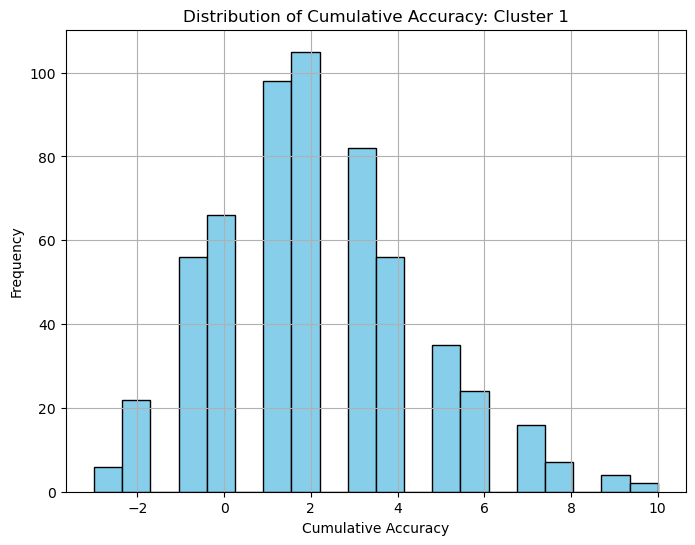

Data does not look normally distributed (reject H0)
Best fit distribution: lognorm


In [20]:
# Distribution of cumulative accuracy: Cluster 1
sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
filtered_data = merged_filtered_data[merged_filtered_data['session'].isin(sessions_cluster_1)].copy()
cum_accuracy_cluster_1 = filtered_data['cumulative_accuracy']

plt.figure(figsize=(8, 6))
plt.hist(cum_accuracy_cluster_1, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cumulative Accuracy: Cluster 1')
plt.xlabel('Cumulative Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check distribution
stat, p = shapiro(cum_accuracy_cluster_1)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(cum_accuracy_cluster_1)
    kstest_stat, _ = stats.kstest(cum_accuracy_cluster_1, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat

print(f"Best fit distribution: {best_fit_name}")

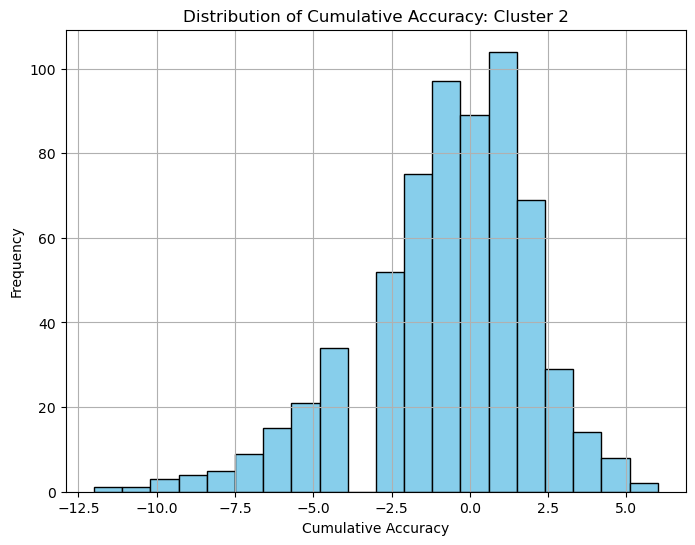

Data does not look normally distributed (reject H0)
Best fit distribution: weibull_min


In [21]:
# Distribution of cumulative accuracy: Cluster 2
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']
filtered_data = merged_filtered_data[merged_filtered_data['session'].isin(sessions_cluster_2)].copy()
cum_accuracy_cluster_2 = filtered_data['cumulative_accuracy']

plt.figure(figsize=(8, 6))
plt.hist(cum_accuracy_cluster_2, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cumulative Accuracy: Cluster 2')
plt.xlabel('Cumulative Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check normality
stat, p = shapiro(cum_accuracy_cluster_2)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(cum_accuracy_cluster_2)
    kstest_stat, _ = stats.kstest(cum_accuracy_cluster_1, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat

print(f"Best fit distribution: {best_fit_name}")

## Modelling

### Cumulative Accuracy

In [129]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: Cumulative Accuracy
# Distribution: beta

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_cumulative_accuracy'] = scaler.fit_transform(merged_filtered_data[['cumulative_accuracy']]) #transforming cumulative_accuracy to fit into (0, 1) range 

formula = 'scaled_cumulative_accuracy ~ np.power(trialno, 2) + (trialno | session)' #accounting for non-linear trend here # random intercept and slope 

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session']
)
result = mixed_model.fit()

print(result.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_cumulative_accuracy
No. Observations: 1211    Method:             REML                      
No. Groups:       74      Scale:              0.0056                    
Min. group size:  5       Log-Likelihood:     1281.9485                 
Max. group size:  40      Converged:          Yes                       
Mean group size:  16.4                                                  
-------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  0.512     0.016  32.993  0.000   0.481   0.542
np.power(trialno, 2)      -0.000     0.000  -1.070  0.285  -0.000   0.000
trialno | session          0.001     0.000   5.931  0.000   0.001   0.002
Group Var                  0.010     0.025                     

In [22]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: cumulative accuracy, cluster 1 
# Distribution: Log-normal

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
data_cluster_1 = merged_filtered_data[merged_filtered_data['session'].isin(sessions_cluster_1)].copy()

min_value = np.min(data_cluster_1['cumulative_accuracy'])
epsilon = 1e-6  # small constant to avoid zero
data_cluster_1['cumulative_accuracy'] += abs(min_value) + epsilon

data_cluster_1['log_cumulative_accuracy'] = np.log(data_cluster_1['cumulative_accuracy'])
data_cluster_1['trialno'] = data_cluster_1['trialno'].astype('category').cat.codes
data_cluster_1['session'] = data_cluster_1['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
data_cluster_1[['log_cumulative_accuracy']] = scaler.fit_transform(data_cluster_1[['log_cumulative_accuracy']]) # it follows a log-normal distribution

formula = 'log_cumulative_accuracy ~ np.power(trialno, 0.5) + (trialno | session)' #non-linear trend #Random intercept and random slope 

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['log_cumulative_accuracy'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

mixed_model = smf.mixedlm(formula, data = data_cluster_1, groups=data_cluster_1['session'])
result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data_cluster_1)

predicted_values = result.predict()

observed_values = data_cluster_1['log_cumulative_accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_cumulative_accuracy
No. Observations: 579     Method:             REML                   
No. Groups:       34      Scale:              0.0087                 
Min. group size:  6       Log-Likelihood:     520.5981               
Max. group size:  39      Converged:          Yes                    
Mean group size:  17.0                                               
----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.873     0.012  74.052  0.000   0.850   0.896
np.power(trialno, 0.5)  0.009     0.004   2.343  0.019   0.001   0.016
trialno | session       0.001     0.000   1.574  0.115  -0.000   0.002
Group Var               0.001     0.004                               

Mean Absolute Error (MAE): 0

In [34]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: cumulative accuracy, cluster 2
# Distribution: weibull

sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']
data_cluster_2 = merged_filtered_data[merged_filtered_data['session'].isin(sessions_cluster_2)].copy()

data_cluster_2['trialno'] = data_cluster_2['trialno'].astype('category').cat.codes
data_cluster_2['session'] = data_cluster_2['session'].astype('category').cat.codes

min_value = np.min(data_cluster_2['cumulative_accuracy'])
epsilon = 1e-6  # small constant to avoid zero
data_cluster_2['cumulative_accuracy'] += abs(min_value) + epsilon

data_cluster_2['transformed_cumulative_accuracy'] = np.log(data_cluster_2['cumulative_accuracy'] + 0.001) # Transform cumulative accuracy to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
data_cluster_2['scaled_transformed_cumulative_accuracy'] = scaler.fit_transform(data_cluster_2[['transformed_cumulative_accuracy']])

formula = 'scaled_transformed_cumulative_accuracy ~ np.power(trialno, 0.5) + (trialno | session)' # accounting for non-linearity #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_cumulative_accuracy'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

mixed_model = sm.MixedLM.from_formula(formula, data=data_cluster_2, groups=data_cluster_2['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = data_cluster_2['scaled_transformed_cumulative_accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_cumulative_accuracy
No. Observations: 632     Method:             REML                                  
No. Groups:       40      Scale:              0.0016                                
Min. group size:  5       Log-Likelihood:     1091.6604                             
Max. group size:  40      Converged:          Yes                                   
Mean group size:  15.8                                                              
---------------------------------------------------------------------------------------
                             Coef.     Std.Err.       z       P>|z|    [0.025    0.975]
---------------------------------------------------------------------------------------
Intercept                     0.973       0.006    168.061    0.000     0.962     0.985
np.power(trialno, 0.5)       -0.004       0.001     -3.011    0.003    -0.007

### Accuracy

In [46]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy
# Distribution: binomial

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

formula = 'accuracy ~ np.power(trialno, 2) + (trialno | session)'

#LOO cross-validation
#def loo_cv(model, formula, data):
#    mae_scores = []
#    n = len(data)
#    data.reset_index(drop=True, inplace=True)  # Reset index
#    for i in range(n):
#        train_data = data.drop(index=i)
#        test_data = data.iloc[[i]]
#        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
#        result = model_fit.fit()
#        predicted_value = result.predict(test_data)
#        true_value = test_data['accuracy'].values[0]
#        mae_scores.append(np.abs(predicted_value - true_value))
#    return np.mean(mae_scores)

# Fit the mixed effects model
mixed_model = sm.MixedLM.from_formula(formula, groups=merged_filtered_data['session'], data=merged_filtered_data)

# Fit the model
result= mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data)

predicted_values = result.predict()

observed_values = merged_filtered_data['accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   accuracy 
No. Observations:     1211      Method:               REML     
No. Groups:           74        Scale:                0.2483   
Min. group size:      5         Log-Likelihood:       -896.5006
Max. group size:      40        Converged:            Yes      
Mean group size:      16.4                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.527    0.035 14.860 0.000  0.458  0.597
np.power(trialno, 2) -0.000    0.000 -0.002 0.998 -0.000  0.000
trialno | session    -0.000    0.001 -0.185 0.853 -0.002  0.001
Group Var             0.003    0.009                           

Mean Absolute Error (MAE): 0.49908990741338927
Mean Squared Error (MSE): 0.24954766346296695


In [32]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy - cluster 1
# Distribution: binomial

data_cluster_1['trialno'] = data_cluster_1['trialno'].astype('category').cat.codes
data_cluster_1['session'] = data_cluster_1['session'].astype('category').cat.codes

formula = 'accuracy ~ np.power(trialno, 0.5) + (trialno | session)'

#LOO cross-validation
#def loo_cv(model, formula, data):
#    mae_scores = []
#    n = len(data)
#    data.reset_index(drop=True, inplace=True)  # Reset index
#    for i in range(n):
#        train_data = data.drop(index=i)
#        test_data = data.iloc[[i]]
#        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
#        result = model_fit.fit()
#        predicted_value = result.predict(test_data)
#        true_value = test_data['accuracy'].values[0]
#        mae_scores.append(np.abs(predicted_value - true_value))
#    return np.mean(mae_scores)

# Fit the mixed effects model
mixed_model = sm.MixedLM.from_formula(formula, groups=data_cluster_1['session'], data=data_cluster_1)

# Fit the model
result= mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data_cluster_1)

predicted_values = result.predict()

observed_values = data_cluster_1['accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         accuracy
No. Observations:          579             Method:                     REML    
No. Groups:                34              Scale:                      0.2366  
Min. group size:           6               Log-Likelihood:             inf     
Max. group size:           39              Converged:                  Yes     
Mean group size:           17.0                                                
-------------------------------------------------------------------------------
                       Coef.    Std.Err.    z    P>|z|    [0.025       0.975]  
-------------------------------------------------------------------------------
Intercept              -0.000 3987965.717 -0.000 1.000 -7816269.176 7816269.176
np.power(trialno, 0.5) -0.015       0.022 -0.662 0.508       -0.058       0.029
trialno | session       0.002       0.003  0.851 0.395       

In [33]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy - cluster 2
# Distribution: binomial

data_cluster_2['trialno'] = data_cluster_2['trialno'].astype('category').cat.codes
data_cluster_2['session'] = data_cluster_2['session'].astype('category').cat.codes

formula = 'accuracy ~ trialno + np.power(trialno, 2) + (trialno | session)'

#LOO cross-validation
#def loo_cv(model, formula, data):
#    mae_scores = []
#    n = len(data)
#    data.reset_index(drop=True, inplace=True)  # Reset index
#    for i in range(n):
#        train_data = data.drop(index=i)
#        test_data = data.iloc[[i]]
#        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
#        result = model_fit.fit()
#        predicted_value = result.predict(test_data)
#        true_value = test_data['accuracy'].values[0]
#        mae_scores.append(np.abs(predicted_value - true_value))
#    return np.mean(mae_scores)

# Fit the mixed effects model
mixed_model = sm.MixedLM.from_formula(formula, groups=data_cluster_2['session'], data=data_cluster_2)

# Fit the model
result= mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data_cluster_2)

predicted_values = result.predict()

observed_values = data_cluster_2['accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   accuracy 
No. Observations:     632       Method:               REML     
No. Groups:           40        Scale:                0.2461   
Min. group size:      5         Log-Likelihood:       -475.4553
Max. group size:      40        Converged:            No       
Mean group size:      15.8                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.468    0.047 10.051 0.000  0.376  0.559
trialno              -0.003    0.002 -1.507 0.132 -0.007  0.001
np.power(trialno, 2)  0.000    0.000  1.000 0.317 -0.000  0.001
trialno | session     0.001    0.002  0.606 0.544 -0.002  0.005
Group Var             0.002                                    

Mean Absolute Error (MAE): 0.4907504081131743
Mean S

### Total trial duration

In [48]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durPeriodTotal'] = np.log(merged_filtered_data['durPeriodTotal'] + 0.001) # Transform trial duration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durPeriodTotal'] = scaler.fit_transform(merged_filtered_data[['transformed_durPeriodTotal']])

formula = 'scaled_transformed_durPeriodTotal ~ trialno + np.power(trialno, 2) + (trialno | session)' # Quadratic term for trialno (non-linearity) #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_durPeriodTotal'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)
    
mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durPeriodTotal']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durPeriodTotal
No. Observations: 1211    Method:             REML                             
No. Groups:       74      Scale:              0.0454                           
Min. group size:  5       Log-Likelihood:     75.2887                          
Max. group size:  40      Converged:          Yes                              
Mean group size:  16.4                                                         
----------------------------------------------------------------------------------
                         Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------------
Intercept                 0.432       0.025    17.052    0.000     0.383     0.482
trialno                   0.002       0.001     3.264    0.001     0.001     0.003
np.power(trialno, 2)      0.000       0.000   

### Exploration Period Duration 

In [10]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

durExplorationPeriod_2d = merged_filtered_data['durExplorationPeriod'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_durExplorationPeriod'] = scaler.fit_transform(durExplorationPeriod_2d)

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_durExplorationPeriod'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

formula = 'scaled_durExplorationPeriod ~ trialno + np.power(trialno, 2) + (trialno | session)' #non-linear trend #random intercept and random slope

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session']
)
result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_durExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durExplorationPeriod
No. Observations: 1211    Method:             REML                       
No. Groups:       74      Scale:              0.0492                     
Min. group size:  5       Log-Likelihood:     34.9997                    
Max. group size:  40      Converged:          Yes                        
Mean group size:  16.4                                                   
---------------------------------------------------------------------------
                       Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------
Intercept               0.207      0.024    8.551   0.000    0.160    0.255
trialno                 0.002      0.001    2.862   0.004    0.001    0.003
np.power(trialno, 2)    0.000      0.000    1.022   0.307   -0.000    0.000
trialno | session      -0.000      0.001   -

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Decision Period Duration

In [15]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: Log-normal

merged_filtered_data['log_durDecisionPeriod'] = np.log(merged_filtered_data['durDecisionPeriod'])
merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = StandardScaler() 
merged_filtered_data[['log_durDecisionPeriod']] = scaler.fit_transform(merged_filtered_data[['log_durDecisionPeriod']]) # Decision period duration follows a log-normal distribution

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['log_durDecisionPeriod'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)
    
formula = 'log_durDecisionPeriod ~ trialno + np.power(trialno, 0.5) + (trialno | session)' #Random intercept and random slope #Also accounting for non-linear trend

mixed_model = smf.mixedlm(formula, merged_filtered_data, groups=merged_filtered_data['session'])
result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, data)

predicted_values = result.predict()

observed_values = merged_filtered_data['log_durDecisionPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_durDecisionPeriod
No. Observations: 1211    Method:             REML                 
No. Groups:       74      Scale:              0.8367               
Min. group size:  5       Log-Likelihood:     -1673.8317           
Max. group size:  40      Converged:          Yes                  
Mean group size:  16.4                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.056    0.144  0.388 0.698 -0.226  0.338
trialno                   0.001    0.008  0.145 0.884 -0.014  0.016
np.power(trialno, 0.5)    0.032    0.059  0.545 0.585 -0.083  0.147
trialno | session        -0.003    0.002 -1.521 0.128 -0.008  0.001
Group Var                 0.165    0.042                       

### Fixation Duration of Bottom Cards during Exploration

In [18]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durfixBottomExploration
# Distribution: gamma

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

shape, loc, scale = gamma.fit(merged_filtered_data['durfixBottomExploration'])

merged_filtered_data['transformed_durfixBottomExploration'] = gamma.cdf(merged_filtered_data['durfixBottomExploration'], shape, loc=loc, scale=scale)

scaler = StandardScaler() 
merged_filtered_data[['scaled_transformed_durfixBottomExploration']] = scaler.fit_transform(merged_filtered_data[['transformed_durfixBottomExploration']])

formula = 'scaled_transformed_durfixBottomExploration ~ trialno + np.power(trialno, 2) + (trialno | session)' # accounting for non linear trend #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_durfixBottomExploration'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)
    
mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durfixBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durfixBottomExploration
No. Observations: 1211    Method:             REML                                      
No. Groups:       74      Scale:              0.7906                                    
Min. group size:  5       Log-Likelihood:     -1650.7288                                
Max. group size:  40      Converged:          Yes                                       
Mean group size:  16.4                                                                  
---------------------------------------------------------------------------------------------
                          Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  0.174         0.107       1.627      0.104      -0.036       0.384
trialno                    

### Fixation Duration of top card during decision

In [24]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixDurInTDecision
# Distribution: Weibull 

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixDurInTDecision'] = np.log(merged_filtered_data['FixDurInTDecision'] + 0.001) # Transform FixDurInTDecision to fit a Weibull distribution
FixDurInTDecision_2d = merged_filtered_data['transformed_FixDurInTDecision'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixDurInTDecision'] = scaler.fit_transform(FixDurInTDecision_2d)

formula = 'scaled_transformed_FixDurInTDecision ~ trialno + np.power(trialno, 0.5) + (trialno | session)' # Accounting for non-linearity #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True) 
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_FixDurInTDecision'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)
    
mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixDurInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixDurInTDecision
No. Observations: 1211    Method:             REML                                
No. Groups:       74      Scale:              0.0497                              
Min. group size:  5       Log-Likelihood:     65.5267                             
Max. group size:  40      Converged:          Yes                                 
Mean group size:  16.4                                                            
-------------------------------------------------------------------------------------
                            Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------------------
Intercept                    0.874       0.030    29.343    0.000     0.815     0.932
trialno                      0.001       0.002     0.700    0.484    -0.002     0.005
np.power(tri

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Total number of fixations

In [27]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_FixNb'] = scaler.fit_transform(merged_filtered_data[['FixNb']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_FixNb ~ trialno + np.power(trialno, 0.5) + (trialno | session)' #accounting for non-linear trend here  # random intercept and slope 

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True) 
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_FixNb'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)
    
mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session'], 
)
result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_FixNb']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   scaled_FixNb
No. Observations:    1211      Method:               REML        
No. Groups:          74        Scale:                0.0165      
Min. group size:     5         Log-Likelihood:       692.3671    
Max. group size:     40        Converged:            Yes         
Mean group size:     16.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.289    0.021 14.033 0.000  0.248  0.329
trialno                 0.002    0.001  1.654 0.098 -0.000  0.004
np.power(trialno, 0.5) -0.010    0.008 -1.233 0.217 -0.026  0.006
trialno | session      -0.001    0.000 -1.684 0.092 -0.001  0.000
Group Var               0.004    0.007                           

Mean Absolute Error (MA

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Number of fixations of bottom cards during exploration

In [29]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbInBottomExploration
# Distribution: Weibull 

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixNbInBottomExploration'] = np.log(merged_filtered_data['FixNbInBottomExploration'] + 0.001) # Transform FixNbInBottomExploration to fit a Weibull distribution

scaler = StandardScaler() 
merged_filtered_data[['scaled_transformed_FixNbInBottomExploration']] = scaler.fit_transform(merged_filtered_data[['transformed_FixNbInBottomExploration']])

formula = 'scaled_transformed_FixNbInBottomExploration ~ trialno + np.power(trialno, 2) + (trialno | session)' # Accounting for non-linear trend #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_FixNbInBottomExploration'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixNbInBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbInBottomExploration
No. Observations: 1211    Method:             REML                                       
No. Groups:       74      Scale:              0.7007                                     
Min. group size:  5       Log-Likelihood:     -1594.0418                                 
Max. group size:  40      Converged:          Yes                                        
Mean group size:  16.4                                                                   
----------------------------------------------------------------------------------------------
                           Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   0.013         0.116       0.111      0.911      -0.215       0.241
trialno         

### Number of fixations of top card during decision

In [32]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbTD
# Distribution: gamma

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

# Fit a gamma distribution to cumulative_accuracy
shape, loc, scale = gamma.fit(merged_filtered_data['FixNbInTDecision'])

# Transform FixNbTD to fit a gamma distribution
merged_filtered_data['transformed_FixNbInTDecision'] = gamma.cdf(merged_filtered_data['FixNbInTDecision'], shape, loc=loc, scale=scale)

scaler = StandardScaler() 
merged_filtered_data[['scaled_transformed_FixNbInTDecision']] = scaler.fit_transform(merged_filtered_data[['transformed_FixNbInTDecision']])

formula = 'scaled_transformed_FixNbInTDecision ~ trialno + np.power(trialno, 2) + (trialno | session)' # Quadratic term for trialno (non-linearity) #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_FixNbInTDecision'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixNbInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbInTDecision
No. Observations: 1211    Method:             REML                               
No. Groups:       74      Scale:              0.9153                             
Min. group size:  5       Log-Likelihood:     -1713.1146                         
Max. group size:  40      Converged:          Yes                                
Mean group size:  16.4                                                           
------------------------------------------------------------------------------------
                           Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------------------
Intercept                   0.224       0.090     2.491    0.013     0.048     0.401
trialno                     0.000       0.002     0.130    0.897    -0.004     0.005
np.power(trialno, 2)   

### Number of switches during exploration

In [37]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: SwitchesExplorationPeriod
# Distribution: gamma

merged_filtered_data['trialno'] = merged_filtered_data['trialno'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

shape, loc, scale = gamma.fit(merged_filtered_data['SwitchesExplorationPeriod'])

merged_filtered_data['transformed_SwitchesExplorationPeriod'] = gamma.cdf(merged_filtered_data['SwitchesExplorationPeriod'], shape, loc=loc, scale=scale)

scaler = StandardScaler() 
merged_filtered_data[['scaled_transformed_SwitchesExplorationPeriod']] = scaler.fit_transform(merged_filtered_data[['SwitchesExplorationPeriod']])

formula = 'scaled_transformed_SwitchesExplorationPeriod ~ trialno + np.power(trialno, 2) + (trialno | session)' # Quadratic term for trialno (non-linearity) #random slope and random intercept

#LOO cross-validation
def loo_cv(model, formula, data):
    mae_scores = []
    n = len(data)
    data.reset_index(drop=True, inplace=True)  # Reset index
    for i in range(n):
        train_data = data.drop(index=i)
        test_data = data.iloc[[i]]
        model_fit = sm.MixedLM.from_formula(formula, data=train_data, groups=train_data['session'])
        result = model_fit.fit()
        predicted_value = result.predict(test_data)
        true_value = test_data['scaled_transformed_SwitchesExplorationPeriod'].values[0]
        mae_scores.append(np.abs(predicted_value - true_value))
    return np.mean(mae_scores)

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

#loo_mae = loo_cv(mixed_model, formula, merged_filtered_data)

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
#print("LOO Cross-Validation MAE:", loo_mae)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_SwitchesExplorationPeriod
No. Observations: 1211    Method:             REML                                        
No. Groups:       74      Scale:              0.8183                                      
Min. group size:  5       Log-Likelihood:     -1670.0607                                  
Max. group size:  40      Converged:          Yes                                         
Mean group size:  16.4                                                                    
-----------------------------------------------------------------------------------------------
                            Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    0.100         0.108       0.930      0.353      -0.111       0.311
trialn